In [1]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from copy import deepcopy
from tqdm import tqdm
#just import the stupid graphs from here

(array([119.,  80., 107.,  94., 115.,  97.,  95., 111.,  76., 106.]),
 array([ 0. ,  7.4, 14.8, 22.2, 29.6, 37. , 44.4, 51.8, 59.2, 66.6, 74. ]),
 <a list of 10 Patch objects>)

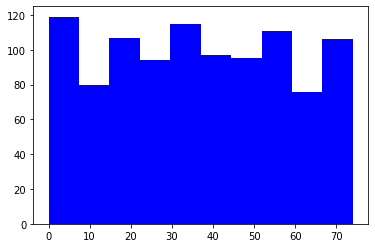

In [6]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    
    return plt.hist(degrees,color = 'blue')
    

plot_degree_dist(Gconfig)


In [7]:
G = nx.generators.random_graphs.erdos_renyi_graph(100,.08)

# G.edges(1)

# Gnew = nx.generators.random_graphs.powerlaw_cluster_graph(1000, 4,.2)
Gbara = nx.generators.random_graphs.barabasi_albert_graph(1000,5)
Gstro = nx.generators.random_graphs.connected_watts_strogatz_graph(1000, 5,.1)

degrees = np.array([1])
while True:
    degrees = np.random.rand(1000)*75
    degrees = degrees.astype(int)
    if np.mod(np.sum(degrees),2) ==0:
        break
        



Gconfig = nx.generators.degree_seq.configuration_model(degrees)

KeyboardInterrupt: 

NameError: name 'Gnew' is not defined

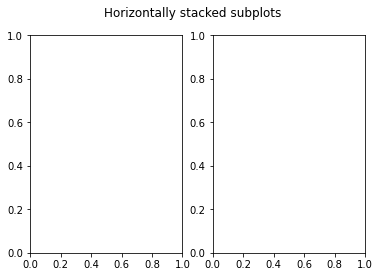

In [4]:
fig, ax = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')


for i in range(2):
    
    
    plt.sca(ax[i])
    # draw all nodes homogeneously, and edge weights as filtered
    nx.draw(Gnew)
    nx.draw(Gconfig)

    

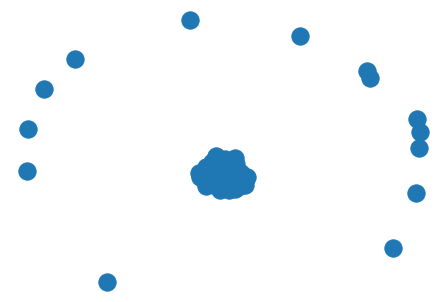

In [5]:
plt.figure()
nx.draw(Gconfig)
plt.show()

In [13]:
class individual_node(object):
    def __init__(self):
        self.susceptible = True
        self.infected = False
        self.vaccinated = False
        self.recovered = False
        self.edges = []
        self.detected = False
        
        
    def infect(self):
        if self.susceptible and not self.vaccinated:
            self.infected = True
            self.susceptible = False
    
    def recover(self):
        if self.infected and not self.susceptible:
            self.recovered = True
            self.infected = False
    
    def vaccinate(self):
        if not self.vaccinated:
            self.vaccinated = True
    
    def set_edges(self,edge_list):
        self.edges = edge_list
        
    def test(self):
        if self.infected:
            self.detected = True
            
    def reset(self):
        self.susceptible = True
        self.infected = False
        self.vaccinated = False
        self.recovered = False
        self.detected = False

class networkSimulator(object):
    def __init__(self,num_nodes,rho,recovery_rate,testing_rate):
        self.num_nodes = num_nodes
        self.node_list = [individual_node() for _ in range(num_nodes)]
        self.rho = rho
        self.recovery_rate = recovery_rate
        self.testing_rate = testing_rate
        self.contact_tracing = 0
        
    def reset_testing(self,new_testing_rate):
        self.testing_rate = new_testing_rate
        
        
        
    def create_network(self,G): #G is an existing nx graph
        assert G.number_of_nodes() == self.num_nodes, 'Graph is the wrong size, check num_nodes'
        self.Graph = G
        for i in range(G.number_of_nodes()):
            edgelist = [v[1] for v in G.edges(i)]
            self.node_list[i].set_edges(edgelist)
            
    def plot_degree_dist(self):
        degrees = [self.Graph.degree(n) for n in self.G.nodes()]
        plt.hist(degrees, color = 'blue')
        plt.show()
        
    def plot_graph_degree_dist(self):
        plt.figure()
        nx.draw(self.Graph)
        plt.draw()
        
    def count_infections(self):
        num_infected = 0
        for i in range(self.num_nodes):
            if self.node_list[i].infected:
                num_infected +=1
        return num_infected
    
    def vaccinate_population(self,vaccinated_percent):
        
        for i in range(G.number_of_nodes()):
            if np.random.rand()<vaccinated_percent:
                self.node_list[i].vaccinate()
        
        
        
    
    def simulate(self,init_infected_nodes= [1,2,3,4,5],num_steps=100):
        
        #infect the initial nodes
        for i in init_infected_nodes:
            self.node_list[i].infect()
            
        #
        infections = []
        
        infections.append(self.count_infections())   
        
        for i in range(num_steps):
            new_infections = []
            new_recoveries = []
            for j in range(self.num_nodes):
                if self.node_list[j].infected:
                    if np.random.rand() < self.recovery_rate:
                        new_recoveries.append(j)
            
            for j in range(self.num_nodes):
                if self.node_list[j].infected and not self.node_list[j].detected:
                    for ii in self.node_list[j].edges:
                        if np.random.rand() < self.rho and self.node_list[ii].susceptible:
                            new_infections.append(ii)
            
            for j in range(self.num_nodes):
                if np.random.rand() < self.testing_rate and self.node_list[j].infected:
                    self.node_list[j].test()
                    if self.node_list[j].detected:
                        for kk in self.node_list[j].edges:
                            if np.random.rand() < self.contact_tracing:
                                self.node_list[kk].test()
                
            for n in new_infections:
                self.node_list[n].infect()
            for n in new_recoveries:
                self.node_list[n].recover()
            
            infections.append(self.count_infections())
        
#         plt.figure()
#         plt.plot(infections)
#         plt.show()
        return np.array(infections)

    def reset_simulation(self):
        for j in range(self.num_nodes):
            self.node_list[j].reset()
            
            
    def simulateR0(self):
        averageLenDisease = int(np.ceil(1/self.recovery_rate))
        R0est = 0
        badcount =0
        for i in range(300):
            infecs = self.simulate(init_infected_nodes = list(np.random.choice(self.num_nodes,3,replace = False)),num_steps = averageLenDisease)
            
            if infecs[0]!=0:
                
                R0est += infecs[-1]/infecs[0]
            else:
                badcount +=1
            self.reset_simulation()
        R0est /= (300-badcount)
        self.R0est = R0est
        print(R0est)
        return R0est
    
    def calculate_testing(self):
        self.recommended_testing = (self.R0est-1)/((1/self.recovery_rate)-1)
        return (self.R0est-1)/((1/self.recovery_rate)-1)
    
    def set_contact_tracing(self,c):
        self.contact_tracing = c
    
    def calculate_percent_infected(self):
        
        avg_num_infected = 0
        
        for i in range(100):
            _= self.simulate(init_infected_nodes = list(np.random.choice(self.num_nodes,5,replace = False)),num_steps = 200)
            #count number still susceptible
            num_susceptible = 0
            for j in range(self.num_nodes):
                if self.node_list[j].susceptible:
                    num_susceptible +=1
                    
            avg_num_infected +=((self.num_nodes - num_susceptible)/self.num_nodes)
        
        return avg_num_infected/100
            

    def plot_results(self,graph_type):
        assert graph_type in ['barabasi','strogatz','erdos','uniform'],'graph_type not recognized'

        fig, ax = plt.subplots(1, 3,figsize=(9,2.65),dpi=200)
        
#         fig.suptitle('Infection Dynamics')

        #plot an example network
        plt.sca(ax[0])
        #NEED TO ADD OPTIONS HERE
        if graph_type =='erdos':
            nx.draw(nx.generators.random_graphs.erdos_renyi_graph(40,.15),node_size=50,width=.4,node_color='blue')
            ax[0].set_title('Erdos Reyni', size=15)
        
        elif graph_type == 'strogatz':
            nx.draw(nx.generators.random_graphs.connected_watts_strogatz_graph(40, 4,.1),node_size=50,width=.4,node_color='blue')
            ax[0].set_title('Small World', size=15)
            
        elif graph_type == 'barabasi':
            nx.draw(nx.generators.random_graphs.barabasi_albert_graph(40,2),node_size=50,width=.4,node_color='blue')
            ax[0].set_title('Scale Free', size=15)
            
        elif graph_type == 'uniform':
            while True:
                degrees = (np.random.rand(40)+.2)*12
                degrees = degrees.astype(int)
                if np.mod(np.sum(degrees),2) ==0:
                    break
            Gdraw = nx.generators.degree_seq.configuration_model(degrees) 
#             Gcc = sorted(nx.connected_components(Gdraw), key=len, reverse=True)
            nx.draw(Gdraw,node_size=50,width =.4,node_color = 'blue')
            ax[0].set_title('Uniform', size=15)
    
        
            

            
        plt.sca(ax[1])
        distplot = plot_degree_dist(self.Graph)
        ax[1].set_title('Degree Distribution', size=15)
        ax[1].yaxis.set_ticklabels([])
        
        figure = plt.gca()

        y_axis = figure.axes.get_yaxis()
        y_axis.set_visible(False)

        plt.sca(ax[2])
        avgInfecs = np.zeros(101)
        self.reset_simulation()
        for i in range(100):
            infecs = self.simulate()
            avgInfecs+=infecs
            self.reset_simulation()
        avgInfecs/=100
        plt.plot(avgInfecs,label = 'Testing Rate = 0',color = 'red')
        plt.legend()
        
         
        
        
        
        avgInfecs = np.zeros(101)
        self.reset_simulation()
        self.reset_testing(self.recommended_testing+.02)
        for i in range(100):
            infecs = self.simulate()
            avgInfecs+=infecs
            self.reset_simulation()
        avgInfecs/=100
        plt.plot(avgInfecs,label = 'Testing Rate = '+str(.26), color = 'blue')
        
        ax[2].yaxis.set_ticklabels([])
        ax[2].set_title('Infection Progression', size=15)
        
#         avgInfecs = np.zeros(101)
#         self.reset_simulation()
#         self.reset_testing(2*self.recommended_testing)
#         for i in range(100):
#             infecs = self.simulate()
#             avgInfecs+=infecs
#             self.reset_simulation()
#         avgInfecs/=100
#         plt.plot(avgInfecs,label = 'Testing Rate = '+str(np.round(2*self.recommended_testing,2)))
        plt.legend(loc = 'upper left')
#         ax[3].set_title('Average Infection Progression: Testing')

        figure = plt.gca()

        y_axis = figure.axes.get_yaxis()
        y_axis.set_visible(False)
    
    
    
        plt.savefig('Plot'+graph_type+'.png')
        plt.show()

            
            #first thing is to initialize four graphs next to one another
        

In [15]:
degrees = np.array([1])
while True:
    degrees = np.random.rand(1000)*75
    degrees = degrees.astype(int)
    if np.mod(np.sum(degrees),2) ==0:
        break

print('creating graph from degree sequence')

Gconfig = nx.generators.degree_seq.configuration_model(degrees)

# Gstro2 = nx.generators.random_graphs.connected_watts_strogatz_graph(1000, 5,.1)

netsim = networkSimulator(1000,rho = .0035,recovery_rate =.06,testing_rate =0)
netsim.create_network(Gconfig)
print('simulating R0')
netsim.simulateR0()

creating graph from degree sequence
simulating R0
4.152222222222227


4.152222222222227

In [231]:
#okay so let's try this with an erdos renyi graph. maybe can we do contourf

# x = np.random.rand(10)
# y = np.random.rand(10)
# plt.scatter(x,y, c = np.random.rand(10),cmap = 'inferno')



#okay so first we need to determine the right rho values for each graph type with
#.06 recovery and 0 testing and 1000 nodes. we want one for 3 and one for 8 (alpha vs delta)

# del netsim

# Gerdos2 = nx.generators.random_graphs.erdos_renyi_graph(1000,.005)
# Gbara2 = nx.generators.random_graphs.barabasi_albert_graph(1000,5)


# degrees = np.array([1])
# while True:
#     degrees = np.random.rand(1000)*75
#     degrees = degrees.astype(int)
#     if np.mod(np.sum(degrees),2) ==0:
#         break

# print('creating graph from degree sequence')

# Gconfig2 = nx.generators.degree_seq.configuration_model(degrees)

# Gstro2 = nx.generators.random_graphs.connected_watts_strogatz_graph(1000, 5,.1)

# netsim = networkSimulator(1000,rho = .0915,recovery_rate =.06,testing_rate =0)
# netsim.create_network(Gerdos2)
# netsim.simulateR0()

# print(netsim.calculate_percent_infected())


#okay then, let's write this simulator. first scatter plot, then make pandas dataframe and export to csv
#(remember index = False)

import pandas as pd


def sarahData(graph_type,R0,contact_tracing,masks, datadict =0):
    assert graph_type in ['barabasi','strogatz','erdos','uniform'],'graph_type not recognized'
    assert R0 in [3,8], 'R0 must be either 3 or 8'
    #contact_tracing is a boolean variable
    #masks is a boolean variable that multiplies rho by .75
    
    if graph_type == 'erdos':
        
        G = nx.generators.random_graphs.erdos_renyi_graph(1000,.005)
        if R0 ==3: 
            rho = .0275
        elif R0 ==8:
            rho = .0435
        
    elif graph_type == 'barabasi':
        
        G = nx.generators.random_graphs.barabasi_albert_graph(1000,5)
        if R0 ==3: 
            rho = .009
        elif R0 ==8:
            rho = .0134
            
    elif graph_type == 'strogatz':
        
        G = nx.generators.random_graphs.connected_watts_strogatz_graph(1000, 5,.1)
        if R0 ==3: 
            rho = .048
        elif R0 ==8:
            rho = .0915
            
    elif graph_type == 'uniform':
        
        while True:
            degrees = np.random.rand(1000)*75
            degrees = degrees.astype(int)
            if np.mod(np.sum(degrees),2) ==0:
                break

        print('creating graph from degree sequence')

        G = nx.generators.degree_seq.configuration_model(degrees)
    
        if R0 ==3: 
            rho = .0031
        elif R0 ==8:
            rho = .00435
            
    netsim = networkSimulator(1000,rho = rho,recovery_rate =.06,testing_rate =0)
    netsim.create_network(G)
    if contact_tracing:
        netsim.set_contact_tracing(.4)
        
    if masks:
        netsim.rho = netsim.rho*.75
        
    if datadict == 0:
    
        datadict = {'Graph':[],'Contact Tracing':[],'Recovery Rate':[],'Masks':[],
               'R0':[],'rho':[],'Testing Rate':[],'Vaccination Rate':[],
               'Percent of Population Infected':[]}
    else:
        pass
    
    netsim.simulateR0()
    
    for i in tqdm(range(250)):
        netsim.reset_simulation()
        #randomly pick v and t
        v = np.random.rand()
        t = np.random.rand()
        
        netsim.reset_testing(t)
        netsim.vaccinate_population(v)
        
        val = netsim.calculate_percent_infected()
        
        datadict['Graph'].append(graph_type)
        if contact_tracing:
            datadict['Contact Tracing'].append(.4)
        else:
            datadict['Contact Tracing'].append(0.)
            
        if masks:
            datadict['Masks'].append('T')
        else:
            datadict['Masks'].append('F')
            
        datadict['Recovery Rate'].append(.06)
        datadict['R0'].append(R0)
        datadict['rho'].append(rho)
        datadict['Testing Rate'].append(np.round(t,4))
        datadict['Vaccination Rate'].append(np.round(v,4))
        datadict['Percent of Population Infected'].append(np.round(val,4))
        
    df = pd.DataFrame(datadict)
    
    return datadict
#     print(df.head())
    
    
#     df.to_csv('SayFayCovidData/CovidData'+graph_type+'R0'+str(R0)+'ContactTracing'+str(contact_tracing)+'Masks'+str(masks)+'.csv',index = False)
#     plt.scatter(datadict['Testing Rate'],datadict['Vaccination Rate'],
#                 c = datadict['Percent of Population Infected'])
#     plt.colorbar()
#     plt.show()
    
# sarahData(graph_type='erdos',R0 =8,contact_tracing=False,masks=False)

for g in ['barabasi','strogatz','erdos','uniform']:
    for R0 in [3,8]:
        for c in [True,False]:
            for m in [True,False]:
                
                if g == 'barabasi' and R0 ==3 and c and m:
                    datadict = sarahData(graph_type=g,R0 =R0,contact_tracing=c,masks=m)
                else:
                    datadict = sarahData(graph_type=g,R0 =R0,contact_tracing=c,masks=m,datadict= datadict)
df = pd.DataFrame(datadict)
df.to_csv('SayFayCovidData/CovidData.csv',index = False)

assert False








Gerdos2 = nx.generators.random_graphs.erdos_renyi_graph(1000,.005)
netsim = networkSimulator(1000,rho = .043,recovery_rate =.06,testing_rate =.21)
netsim.create_network(Gerdos2)
netsim.set_contact_tracing(.5)
netsim.simulateR0()
x = netsim.calculate_testing()
print(x)
assert False



avgProg = np.zeros(101)

for i in range(50):
    netsim.reset_simulation()
    x = netsim.simulate()
    avgProg+=x
plt.plot(avgProg/50)
assert False


vs = []
ts = []
vals = []
for i in tqdm(range(500)):
    
    v = np.random.rand()*.3 #this is the vaccinated percent
    t = np.random.rand()*.3 #this is the testing amount
    Gerdos2 = nx.generators.random_graphs.erdos_renyi_graph(1000,.005)
    
    
    

    netsim = networkSimulator(1000,rho = .043,recovery_rate =.06,testing_rate =0)
    netsim.create_network(Gerdos2)
    
#     netsim.simulateR0()
    
    
    
#     netsim.reset_simulation()
    netsim.reset_testing(t)
    netsim.vaccinate_population(v)
        
    val = netsim.calculate_percent_infected()
    vs.append(v)
    ts.append(t)
    vals.append(val)
    
    
#     print(val)
        

                
        



  0%|          | 0/250 [00:00<?, ?it/s]

1.6366666666666658


  0%|          | 0/250 [00:00<?, ?it/s]

3.1600000000000015


  0%|          | 0/250 [00:00<?, ?it/s]

1.5166666666666657


  0%|          | 0/250 [00:00<?, ?it/s]

2.581111111111113


  0%|          | 0/250 [00:00<?, ?it/s]

3.6033333333333357


  0%|          | 0/250 [00:00<?, ?it/s]

7.652222222222218


  0%|          | 0/250 [00:00<?, ?it/s]

3.1966666666666663


  0%|          | 0/250 [00:00<?, ?it/s]

7.174444444444447


  0%|          | 0/250 [00:00<?, ?it/s]

1.962222222222222


  0%|          | 0/250 [00:00<?, ?it/s]

2.5922222222222215


  0%|          | 0/250 [00:00<?, ?it/s]

1.8644444444444461


  0%|          | 0/250 [00:00<?, ?it/s]

2.524444444444445


  0%|          | 0/250 [00:00<?, ?it/s]

4.5566666666666675


  0%|          | 0/250 [00:00<?, ?it/s]

7.694444444444444


  0%|          | 0/250 [00:00<?, ?it/s]

4.591111111111112


  0%|          | 0/250 [00:00<?, ?it/s]

7.51777777777778


  0%|          | 0/250 [00:00<?, ?it/s]

1.6999999999999993


  0%|          | 0/250 [00:00<?, ?it/s]

2.9477777777777785


  0%|          | 0/250 [00:00<?, ?it/s]

1.638888888888889


  0%|          | 0/250 [00:00<?, ?it/s]

2.903333333333334


  0%|          | 0/250 [00:00<?, ?it/s]

3.9411111111111117


  0%|          | 0/250 [00:00<?, ?it/s]

7.193333333333333


  0%|          | 0/250 [00:00<?, ?it/s]

3.6055555555555556


  0%|          | 0/250 [00:00<?, ?it/s]

6.97888888888889


100%|██████████| 250/250 [02:28<00:00,  1.68it/s]


creating graph from degree sequence


  0%|          | 0/250 [00:00<?, ?it/s]

1.8500000000000008


100%|██████████| 250/250 [02:27<00:00,  1.69it/s]


creating graph from degree sequence


  0%|          | 0/250 [00:00<?, ?it/s]

3.227777777777777


100%|██████████| 250/250 [02:26<00:00,  1.70it/s]


creating graph from degree sequence


  0%|          | 0/250 [00:00<?, ?it/s]

1.803333333333333


100%|██████████| 250/250 [02:27<00:00,  1.69it/s]


creating graph from degree sequence


  0%|          | 0/250 [00:00<?, ?it/s]

2.994444444444444


100%|██████████| 250/250 [02:27<00:00,  1.69it/s]


creating graph from degree sequence


  0%|          | 0/250 [00:00<?, ?it/s]

3.937777777777776


100%|██████████| 250/250 [02:29<00:00,  1.68it/s]


creating graph from degree sequence


  0%|          | 0/250 [00:00<?, ?it/s]

8.185555555555554


100%|██████████| 250/250 [02:26<00:00,  1.71it/s]


creating graph from degree sequence


  0%|          | 0/250 [00:00<?, ?it/s]

3.742222222222224


100%|██████████| 250/250 [02:28<00:00,  1.68it/s]


creating graph from degree sequence


  0%|          | 0/250 [00:00<?, ?it/s]

8.180000000000005


100%|██████████| 250/250 [02:28<00:00,  1.68it/s]


AssertionError: 

<ipython-input-239-c3c9d4bfa035>:3: RuntimeWarning: divide by zero encountered in log
  c = -np.log(datadict['Percent of Population Infected'][750:1000]))


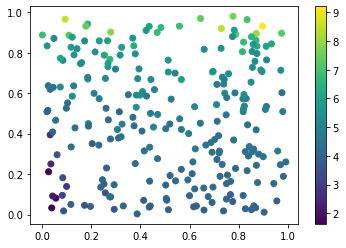

In [239]:
plt.figure()
plt.scatter(datadict['Testing Rate'][750:1000],datadict['Vaccination Rate'][750:1000],
            c = -np.log(datadict['Percent of Population Infected'][750:1000]))
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
plt.scatter(vs,ts,c = vals,s = 70)
plt.xlabel('Percent Vaccinated')
plt.ylabel('Percent Tested')
plt.title('Percent Population Infected')
plt.colorbar()
plt.show()


creating graph from degree sequence
4.125555555555557


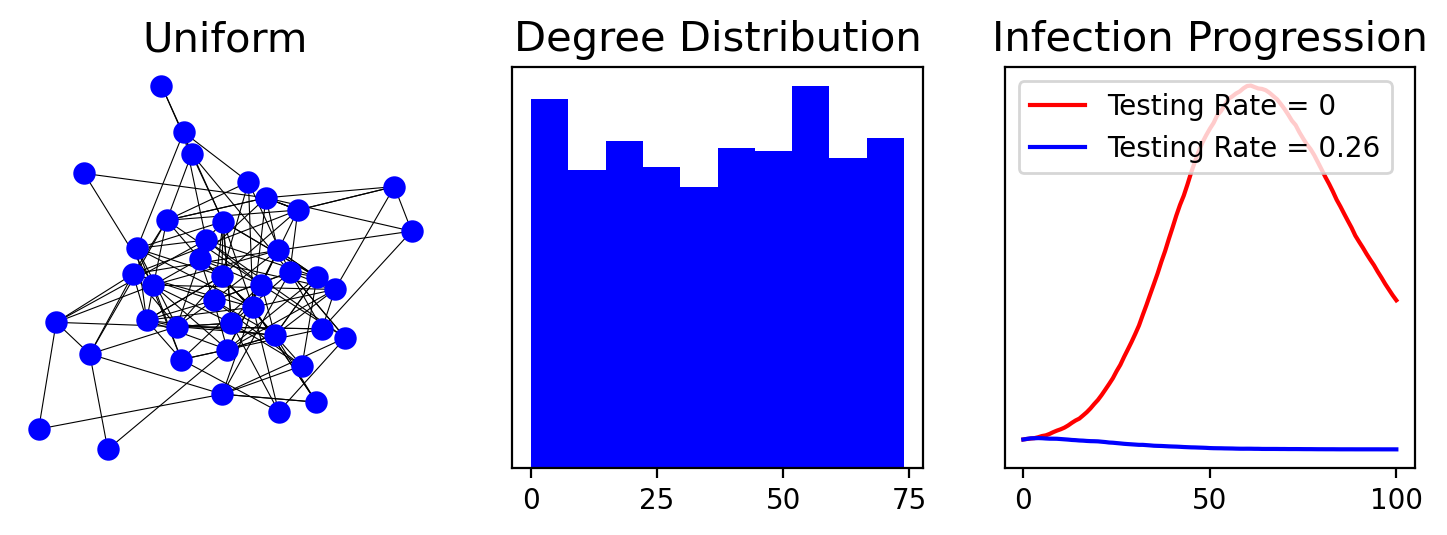

5.772222222222221


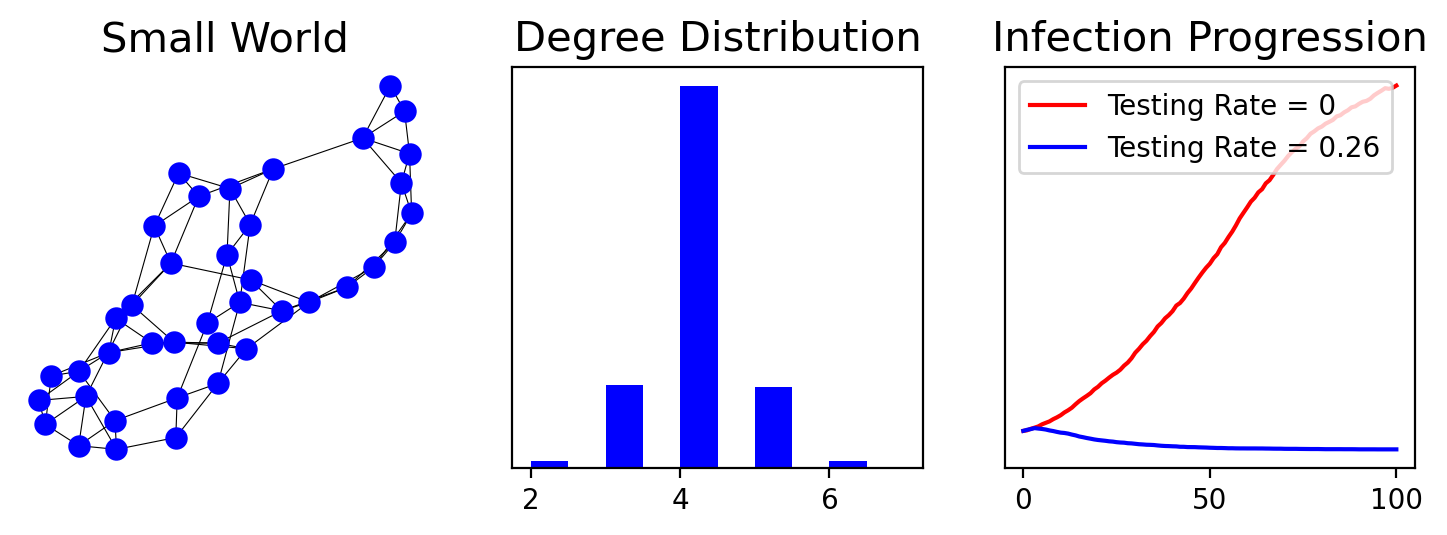

4.765555555555557


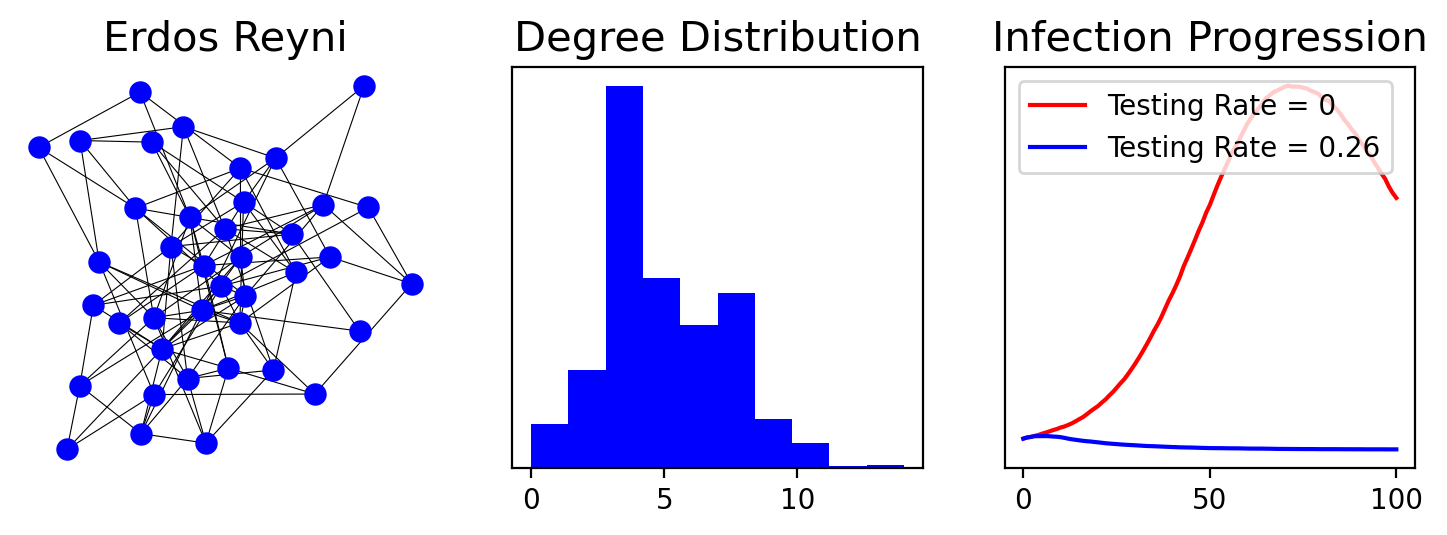

5.091111111111107


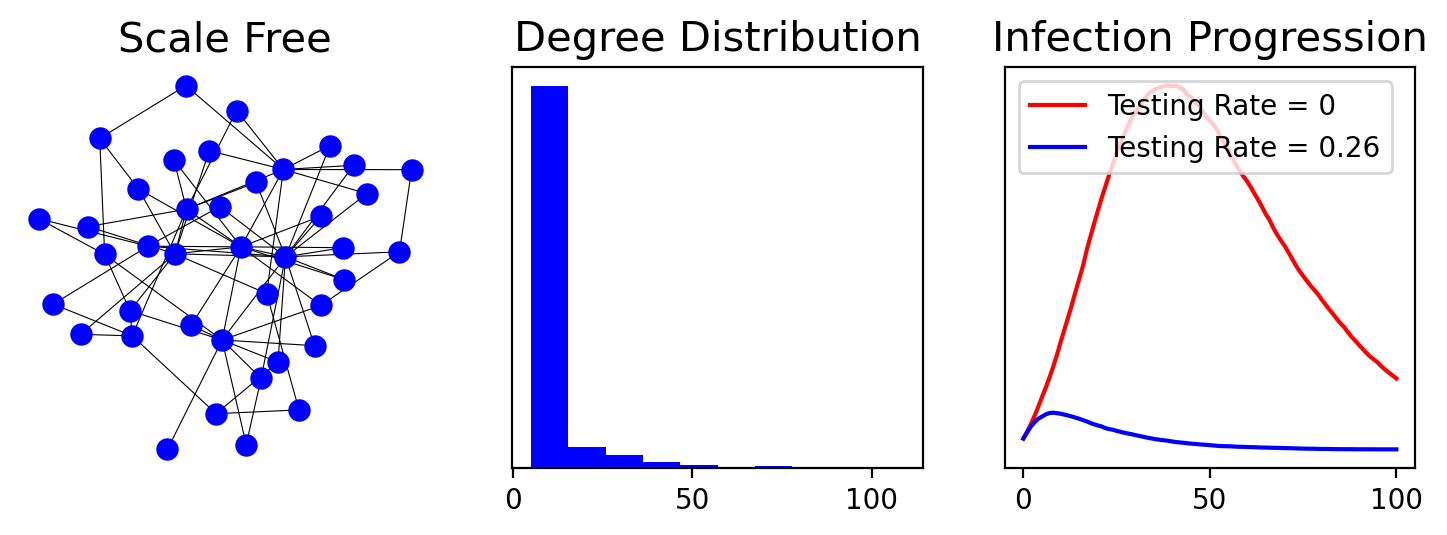

In [14]:
from time import time


degrees = np.array([1])
while True:
    degrees = np.random.rand(1000)*75
    degrees = degrees.astype(int)
    if np.mod(np.sum(degrees),2) ==0:
        break

print('creating graph from degree sequence')

Gconfig = nx.generators.degree_seq.configuration_model(degrees)


G = nx.generators.random_graphs.erdos_renyi_graph(1000,.005)

Gerdos = nx.generators.random_graphs.erdos_renyi_graph(1000,.005)

Gbara = nx.generators.random_graphs.barabasi_albert_graph(1000,5)



Gstro = nx.generators.random_graphs.connected_watts_strogatz_graph(1000, 5,.1)





#okay so just use the parameters below to keep the R0 value close to 5. 
#you'll need to experiment with other parameters for 3 too


netsim = networkSimulator(1000,rho = .0035,recovery_rate =.06,testing_rate =0)
netsim.create_network(Gconfig)
netsim.simulateR0()
netsim.calculate_testing()
netsim.calculate_percent_infected()
netsim.plot_results('uniform')







netsim = networkSimulator(1000,rho = .079,recovery_rate =.06,testing_rate =0)
netsim.create_network(Gstro)
netsim.simulateR0()
netsim.calculate_testing()
netsim.calculate_percent_infected()
netsim.plot_results('strogatz')







netsim = networkSimulator(1000,rho = .0365,recovery_rate =.06,testing_rate =0)
netsim.create_network(Gerdos)
netsim.simulateR0()
netsim.calculate_testing()
netsim.calculate_percent_infected()
netsim.plot_results('erdos')








netsim = networkSimulator(1000,rho = .0115,recovery_rate =.06,testing_rate =0)
netsim.create_network(Gbara)
netsim.simulateR0()
netsim.calculate_testing()
netsim.calculate_percent_infected()
netsim.plot_results('barabasi')


In [ ]:
avg_infecs = np.zeros(101)
for i in tqdm(range(100)):
    netsimcopy = deepcopy(netsim)
    infecs = netsimcopy.simulate()
    
    avg_infecs += infecs/100
    


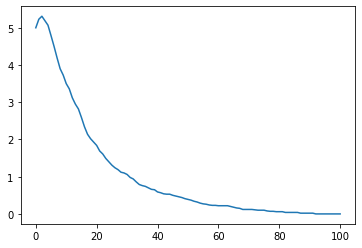

In [300]:
plt.figure()
plt.plot(avg_infecs)
plt.show()
# list(np.random.choice(netsimcopy.num_nodes,5,replace = False))

In [245]:
def estimateR0(netsim):
    r0est = 0
    for i in tqdm(range(100)):
        netsimcopy = deepcopy(netsim)
        infecs = netsimcopy.simulate(init_infected_nodes = list(np.random.choice(netsimcopy.num_nodes,5,replace = False)),num_steps = 16)
#         print(infecs[-1]/infecs[0])
        if infecs[0] != 0:
            r0est += infecs[-1]/infecs[0]
    
    return r0est/100
        
estimateR0(netsim)

100%|██████████| 100/100 [00:03<00:00, 26.15it/s]


8.242

In [123]:
.04*5*16

3.2